In [1]:
%matplotlib inline
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

In [2]:
frames = glob.glob('challenge_frames/output*.jpg')

In [166]:
num_frames = 5
start = 400
images = np.zeros((num_frames, 720, 1280, 3))
for i, fname in enumerate(frames[start:start+num_frames]):
    img = cv2.imread(fname)
    images[i] = img

stacked = np.median(images, axis=0)

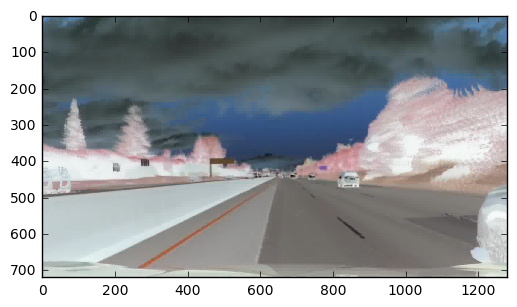

In [167]:
plt.imshow(stacked)

In [168]:
def sobel(gray, orient='x', sobel_kernel=3):
    return cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    retval, output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)

    retval, output = cv2.threshold(mag_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = (np.absolute(np.arctan(sobely/sobelx)))
        dir_binary =  np.zeros_like(absgraddir, dtype=np.uint8)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return dir_binary

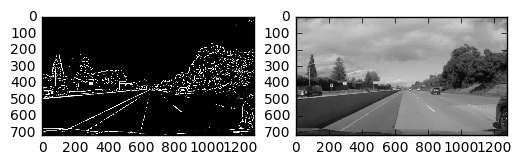

In [175]:
hls = cv2.cvtColor(images[0].astype(np.uint8), cv2.COLOR_RGB2HLS)

gray = (cv2.cvtColor(images[0].astype(np.uint8), cv2.COLOR_RGB2GRAY))
blur = cv2.GaussianBlur(gray, (11, 11), 0)
laplacian = cv2.Laplacian(gray,cv2.CV_64F, ksize=15)

gray_blur = cv2.cvtColor(stacked.astype(np.uint8), cv2.COLOR_RGB2GRAY)
_, gray_binary = cv2.threshold(gray_blur.astype('uint8'), 130, 255, cv2.THRESH_BINARY)

lim =  0.05*np.min(laplacian)
# ulim = 0.15*np.min(laplacian)
l1 = (laplacian < lim).astype(np.uint8)
# l2 = (laplacian > ulim).astype(np.uint8)

# l = np.clip(cv2.bitwise_and(l1, l2), 0, 1).astype('uint8')
plt.subplot(1,2,1)
plt.imshow(l1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gray, cmap='gray')

ksize = 11
sobelx = sobel(gray, orient='x', sobel_kernel=ksize)
gradx = abs_sobel_thresh(sobelx, thresh=(60, 70))

sobely = sobel(gray, orient='y', sobel_kernel=ksize)
grady = abs_sobel_thresh(sobely, thresh=(50, 120))
mag_binary = mag_thresh(sobelx, sobely, thresh=(50, 100))

comb = np.clip(cv2.bitwise_and(gray_binary, cv2.bitwise_or(l1, grady)), 0, 1).astype('uint8')

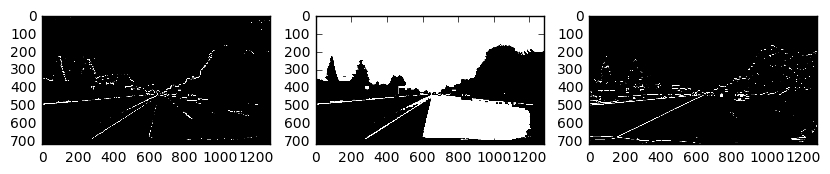

In [176]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(comb, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(gray_binary, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(grady, cmap='gray')
plt.show()